In [43]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import os
from nltk.sentiment.vader import SentimentIntensityAnalyzer
print(os.listdir("../input"))

['resources.csv', 'train.csv', 'test.csv', 'sample_submission.csv']


/opt/conda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [45]:
data = pd.read_csv('../input/train.csv')
data = data.drop(['id','teacher_id','teacher_prefix','school_state','project_submitted_datetime','project_grade_category','project_subject_categories',
                 'project_subject_subcategories','teacher_number_of_previously_posted_projects'], axis=1)

In [64]:
def split_into_approved_rejected(df):
    df_approved = df[df['project_is_approved'] == 1].drop('project_is_approved', axis=1)
    df_rejected = df[df['project_is_approved'] == 0].drop('project_is_approved', axis=1)
    return(df_approved,df_rejected)

# Examining project titles

In [46]:
titles = data.drop(['project_essay_1','project_essay_2','project_essay_3','project_essay_4','project_resource_summary'], axis=1)

Pre-processing to clean up the titles...there might be more to clean up, but it's hard to tell at the moment beyond the first 50 entries

In [47]:
pattern = r'\\([a-zA-Z]|")'
titles['project_title'] = titles['project_title'].str.replace(pattern,'')
titles['project_title'] = titles['project_title'].apply(str.lower)

I have an idea of what the titles look like. It might be worth looking at how the title lengths and the title sentiments correlate with the approval rates. I should note that this is inspired from one of the top public kernels right now, though it only has a word cloud and frequency counts. It doesn't really compare the approved/rejected proportions.

From experience, I would argue that interesting and succinct titles are more likely to catch the eye. I could list a few things down:
1. Titles that are variants of common phrases (e.g. "Keep Calm and Carry On" and "Keep Calm and Dance On")
2. Titles that have alliteration
3. Titles that are shorter (an observation made by a top kernel)
4. Titles that make you feel good

I think items 2, 3, and 4 would be a lot easier to detect, and 1 would require a large list of various phrases...I'm not sure that I would have time to compile such a thing. In short, I'm looking for some rhetorical strategies

In [48]:
titles['project_title_tokenized'] = titles['project_title'].apply(nltk.word_tokenize)

In [49]:
titles['title_length'] = titles['project_title_tokenized'].apply(len)

In [50]:
titles['getting_excited'] = titles['project_title_tokenized'].apply(lambda x: '!' in x)

I'm going to attempt to use the pre-trained NLTK analyzer Vader to analyze sentiment in the titles. I'll be honest and say that I'm not exactly sure how the sentiment analyzer outputs the compound/neg/neu/pos values, but what seems to happen is that (as expected) the negative and positive values tend to cancel each other out, and the neutral score seems to add or multiply one of the values (I can't tell exactly since there are hardly examples with negative compound scores).

In [56]:
sentiment_analyzer = SentimentIntensityAnalyzer()
# note that the polarity scores works on non-tokenized sentences only

def get_compound_score(sentence):
    sentiment_score = sentiment_analyzer.polarity_scores(sentence)
    return(sentiment_score['compound'])

titles['sentiment_compound_score'] = titles['project_title'].apply(get_compound_score)

In [59]:
titles.head(20)

,project_title,project_is_approved,project_title_tokenized,title_length,getting_excited,sentiment_compound_score
0,super sight word centers,1,"[super, sight, word, centers]",4,False,0.5994
1,keep calm and dance on,0,"[keep, calm, and, dance, on]",5,False,0.3182
2,lets 3doodle to learn,1,"[lets, 3doodle, to, learn]",4,False,0.0000
3,kid inspired equipment to increase activities ...,0,"[kid, inspired, equipment, to, increase, activ...",10,False,0.8957
4,we need clean water for our culinary arts class!,1,"[we, need, clean, water, for, our, culinary, a...",10,True,0.4574
5,need to reach our virtual mentors!!!,1,"[need, to, reach, our, virtual, mentors, !, !, !]",9,True,0.2444
6,active kindergartners,1,"[active, kindergartners]",2,False,0.4019
7,fabulous firsties-wiggling to learn!,1,"[fabulous, firsties-wiggling, to, learn, !]",5,True,0.5707
8,wobble chairs help fidgety kids focus,1,"[wobble, chairs, help, fidgety, kids, focus]",6,False,0.0772
9,snuggle up with a good book,1,"[snuggle, up, with, a, good, book]",6,False,0.4404


And here you can see some of the results. Some of the compound scores I don't quite understand, e.g. row 15 with "a comfy seat!". I'd have thought that would be a bit more positive, since "comfy" has a good conotation. However, I think aside from mistakes like that the sentiment compound score does a pretty great job. Now I'm going to clean up the table a bit and examine some of these features one-by-one.

In [60]:
titles_features = titles.drop(['project_title','project_title_tokenized'], axis=1)

In [65]:
titles_features_approved, titles_features_rejected = split_into_approved_rejected(titles_features)

In [84]:
title_length_counts_approved = titles_features_approved['title_length'].value_counts(normalize=True)
title_length_counts_rejected = titles_features_rejected['title_length'].value_counts(normalize=True)

In [86]:
title_length_counts_approved = title_length_counts_approved.reset_index().rename(columns={'index':'length','title_length':'frequency'})
title_length_counts_rejected = title_length_counts_rejected.reset_index().rename(columns={'index':'length','title_length':'frequency'})

In [91]:
title_length_counts_approved = title_length_counts_approved.sort_values('length')
title_length_counts_rejected = title_length_counts_rejected.sort_values('length')

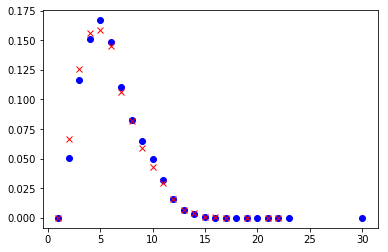

In [100]:
plt.plot(title_length_counts_approved['length'], title_length_counts_approved['frequency'], 'ob',
         title_length_counts_rejected['length'], title_length_counts_rejected['frequency'], 'xr')

It turns out that the distributions look about the same. I wouldn't use the title lengths as a predictor.

The next thing to look at is how excited the title seems to be. I didn't realize this at first, but the sentiment analyzer doesn't seem to take into account the exclamation marks, even in a neutral score. Taking into account the exclamation marks would be something to look into as its own entity.

# Examining project essays

# Examining resource summaries